In [2]:
import sys
print(sys.executable)


/Users/irfan/Documents/0. KULIAH/SEMESTER 7/PBA/FP_PBA/.venv/bin/python


In [3]:
import pandas as pd
import numpy as np
import torch

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import (
    accuracy_score,
    classification_report,
    confusion_matrix
)

from transformers import (
    AutoTokenizer,
    AutoModelForSequenceClassification,
    Trainer,
    TrainingArguments
)

import matplotlib.pyplot as plt
import seaborn as sns


In [4]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Device:", device)


Device: cpu


In [5]:
# path menyesuaikan struktur project kamu
non_aug_path = "Code/Data/02.cleaned_gojek_text_final.csv"
aug_path     = "Code/Data/03.gojek_text_balanced_v2.csv"

df_non_aug = pd.read_csv(non_aug_path)
df_aug     = pd.read_csv(aug_path)

print(df_non_aug.shape)
print(df_aug.shape)


(158, 9)
(459, 10)


In [6]:
TEXT_COL = "stemmed_text"
LABEL_COL = "sentiment"

df_non_aug = df_non_aug[[TEXT_COL, LABEL_COL]].dropna()
df_aug = df_aug[[TEXT_COL, LABEL_COL, "is_augmented"]].dropna()

df_non_aug.head()


,stemmed_text,sentiment
0,yogyakarta perintah menteri hubung bijak naik ...,neutral
1,rencana perintah naik tarif dasar ojek online ...,neutral
2,teliti guna ojol tolak naik tarif ilustrasi tu...,positive
3,kaji ubah tarif ojek online ikut regulasi peri...,positive
4,rised nilai terap naik tarif ojol nilai risiko...,neutral


In [7]:
label_encoder = LabelEncoder()

df_non_aug[LABEL_COL] = label_encoder.fit_transform(df_non_aug[LABEL_COL])
df_aug[LABEL_COL] = label_encoder.transform(df_aug[LABEL_COL])

label_mapping = dict(zip(label_encoder.classes_, label_encoder.transform(label_encoder.classes_)))
label_mapping


{'negative': np.int64(0), 'neutral': np.int64(1), 'positive': np.int64(2)}

In [8]:
X_train_non, X_test_non, y_train_non, y_test_non = train_test_split(
    df_non_aug[TEXT_COL],
    df_non_aug[LABEL_COL],
    test_size=0.2,
    random_state=42,
    stratify=df_non_aug[LABEL_COL]
)

X_train_aug, _, y_train_aug, _ = train_test_split(
    df_aug[TEXT_COL],
    df_aug[LABEL_COL],
    test_size=0.2,
    random_state=42,
    stratify=df_aug[LABEL_COL]
)


In [9]:
MODEL_NAME = "indobenchmark/indobert-base-p1"

tokenizer = AutoTokenizer.from_pretrained(MODEL_NAME)


In [10]:
def tokenize_texts(texts):
    return tokenizer(
        list(texts),
        padding=True,
        truncation=True,
        max_length=128
    )


In [11]:
train_enc_non = tokenize_texts(X_train_non)
test_enc_non  = tokenize_texts(X_test_non)

train_enc_aug = tokenize_texts(X_train_aug)


In [12]:
class SentimentDataset(torch.utils.data.Dataset):
    def __init__(self, encodings, labels):
        self.encodings = encodings
        self.labels = labels.tolist()

    def __getitem__(self, idx):
        item = {key: torch.tensor(val[idx]) for key, val in self.encodings.items()}
        item["labels"] = torch.tensor(self.labels[idx])
        return item

    def __len__(self):
        return len(self.labels)


In [13]:
train_dataset_non = SentimentDataset(train_enc_non, y_train_non)
test_dataset_non  = SentimentDataset(test_enc_non, y_test_non)

train_dataset_aug = SentimentDataset(train_enc_aug, y_train_aug)


In [14]:
model = AutoModelForSequenceClassification.from_pretrained(
    MODEL_NAME,
    num_labels=3
).to(device)


Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [16]:
training_args = TrainingArguments(
    output_dir="./model/indobert_gojek",
    eval_strategy="epoch",
    save_strategy="epoch",
    learning_rate=2e-5,
    per_device_train_batch_size=8,
    per_device_eval_batch_size=8,
    num_train_epochs=3,
    weight_decay=0.01,
    logging_dir="./logs",
    load_best_model_at_end=True,
    report_to="none"
)


In [17]:
def compute_metrics(eval_pred):
    logits, labels = eval_pred
    preds = np.argmax(logits, axis=1)
    return {
        "accuracy": accuracy_score(labels, preds)
    }


In [18]:
# ===============================
# 🚀 EKSPERIMEN 1: NON-AUGMENTED
# ===============================

In [19]:
trainer_non = Trainer(
    model=model,
    args=training_args,
    train_dataset=train_dataset_non,
    eval_dataset=test_dataset_non,
    compute_metrics=compute_metrics
)

trainer_non.train()


/Users/irfan/Documents/0. KULIAH/SEMESTER 7/PBA/FP_PBA/.venv/lib/python3.13/site-packages/torch/utils/data/dataloader.py:692: UserWarning: 'pin_memory' argument is set as true but not supported on MPS now, device pinned memory won't be used.
  warnings.warn(warn_msg)


Epoch,Training Loss,Validation Loss,Accuracy
1,No log,0.893556,0.500000
2,No log,0.893444,0.500000
3,No log,0.886331,0.500000


/Users/irfan/Documents/0. KULIAH/SEMESTER 7/PBA/FP_PBA/.venv/lib/python3.13/site-packages/torch/utils/data/dataloader.py:692: UserWarning: 'pin_memory' argument is set as true but not supported on MPS now, device pinned memory won't be used.
  warnings.warn(warn_msg)
/Users/irfan/Documents/0. KULIAH/SEMESTER 7/PBA/FP_PBA/.venv/lib/python3.13/site-packages/torch/utils/data/dataloader.py:692: UserWarning: 'pin_memory' argument is set as true but not supported on MPS now, device pinned memory won't be used.
  warnings.warn(warn_msg)


TrainOutput(global_step=48, training_loss=0.8865843613942465, metrics={'train_runtime': 93.0527, 'train_samples_per_second': 4.062, 'train_steps_per_second': 0.516, 'total_flos': 24864217975296.0, 'train_loss': 0.8865843613942465, 'epoch': 3.0})

In [20]:
pred_non = trainer_non.predict(test_dataset_non)
y_pred_non = np.argmax(pred_non.predictions, axis=1)

print("Accuracy:", accuracy_score(y_test_non, y_pred_non))
print(classification_report(y_test_non, y_pred_non, target_names=label_encoder.classes_))


/Users/irfan/Documents/0. KULIAH/SEMESTER 7/PBA/FP_PBA/.venv/lib/python3.13/site-packages/torch/utils/data/dataloader.py:692: UserWarning: 'pin_memory' argument is set as true but not supported on MPS now, device pinned memory won't be used.
  warnings.warn(warn_msg)


Accuracy: 0.5
              precision    recall  f1-score   support

    negative       0.00      0.00      0.00         2
     neutral       0.43      0.21      0.29        14
    positive       0.52      0.81      0.63        16

    accuracy                           0.50        32
   macro avg       0.32      0.34      0.31        32
weighted avg       0.45      0.50      0.44        32



/Users/irfan/Documents/0. KULIAH/SEMESTER 7/PBA/FP_PBA/.venv/lib/python3.13/site-packages/sklearn/metrics/_classification.py:1833: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", result.shape[0])
/Users/irfan/Documents/0. KULIAH/SEMESTER 7/PBA/FP_PBA/.venv/lib/python3.13/site-packages/sklearn/metrics/_classification.py:1833: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", result.shape[0])
/Users/irfan/Documents/0. KULIAH/SEMESTER 7/PBA/FP_PBA/.venv/lib/python3.13/site-packages/sklearn/metrics/_classification.py:1833: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` 

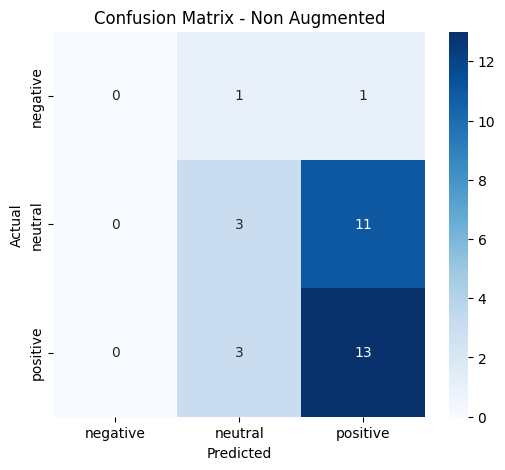

In [21]:
cm = confusion_matrix(y_test_non, y_pred_non)

plt.figure(figsize=(6,5))
sns.heatmap(cm, annot=True, fmt="d",
            xticklabels=label_encoder.classes_,
            yticklabels=label_encoder.classes_,
            cmap="Blues")
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.title("Confusion Matrix - Non Augmented")
plt.show()


In [22]:
# ===============================
# 🚀 EKSPERIMEN 2: AUGMENTED
# ===============================

In [23]:
model_aug = AutoModelForSequenceClassification.from_pretrained(
    MODEL_NAME,
    num_labels=3
).to(device)


Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [24]:
trainer_aug = Trainer(
    model=model_aug,
    args=training_args,
    train_dataset=train_dataset_aug,
    eval_dataset=test_dataset_non,
    compute_metrics=compute_metrics
)

trainer_aug.train()


/Users/irfan/Documents/0. KULIAH/SEMESTER 7/PBA/FP_PBA/.venv/lib/python3.13/site-packages/torch/utils/data/dataloader.py:692: UserWarning: 'pin_memory' argument is set as true but not supported on MPS now, device pinned memory won't be used.
  warnings.warn(warn_msg)


Epoch,Training Loss,Validation Loss,Accuracy
1,No log,1.276265,0.125000
2,No log,1.099202,0.281250
3,No log,1.048403,0.406250


Error: command buffer exited with error status.
	The Metal Performance Shaders operations encoded on it may not have completed.
	Error: 
	(null)
	Insufficient Memory (00000008:kIOGPUCommandBufferCallbackErrorOutOfMemory)
	<AGXG14GFamilyCommandBuffer: 0x31f2f90e0>
    label = <none> 
    device = <AGXG14GDevice: 0x1627d9600>
        name = Apple M2 
    commandQueue = <AGXG14GFamilyCommandQueue: 0x121bc6c00>
        label = <none> 
        device = <AGXG14GDevice: 0x1627d9600>
            name = Apple M2 
    retainedReferences = 1
Error: command buffer exited with error status.
	The Metal Performance Shaders operations encoded on it may not have completed.
	Error: 
	(null)
	Insufficient Memory (00000008:kIOGPUCommandBufferCallbackErrorOutOfMemory)
	<AGXG14GFamilyCommandBuffer: 0x31f0c9830>
    label = <none> 
    device = <AGXG14GDevice: 0x1627d9600>
        name = Apple M2 
    commandQueue = <AGXG14GFamilyCommandQueue: 0x121bc6c00>
        label = <none> 
        device = <AGXG14GDev

TrainOutput(global_step=138, training_loss=0.9533395076143569, metrics={'train_runtime': 1186.1274, 'train_samples_per_second': 0.928, 'train_steps_per_second': 0.116, 'total_flos': 72421968229632.0, 'train_loss': 0.9533395076143569, 'epoch': 3.0})

In [25]:
pred_aug = trainer_aug.predict(test_dataset_non)
y_pred_aug = np.argmax(pred_aug.predictions, axis=1)

print("Accuracy:", accuracy_score(y_test_non, y_pred_aug))
print(classification_report(y_test_non, y_pred_aug, target_names=label_encoder.classes_))


/Users/irfan/Documents/0. KULIAH/SEMESTER 7/PBA/FP_PBA/.venv/lib/python3.13/site-packages/torch/utils/data/dataloader.py:692: UserWarning: 'pin_memory' argument is set as true but not supported on MPS now, device pinned memory won't be used.
  warnings.warn(warn_msg)


Accuracy: 0.40625
              precision    recall  f1-score   support

    negative       0.00      0.00      0.00         2
     neutral       0.47      0.64      0.55        14
    positive       0.67      0.25      0.36        16

    accuracy                           0.41        32
   macro avg       0.38      0.30      0.30        32
weighted avg       0.54      0.41      0.42        32



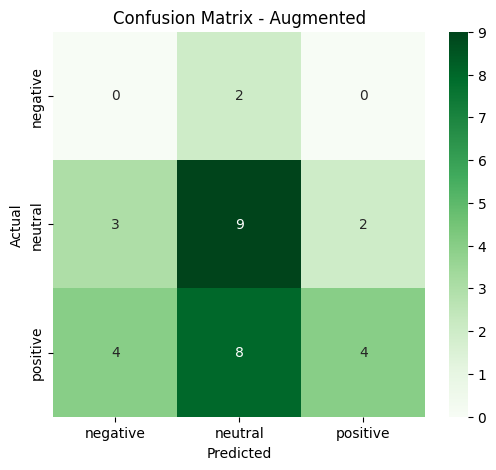

In [26]:
cm_aug = confusion_matrix(y_test_non, y_pred_aug)

plt.figure(figsize=(6,5))
sns.heatmap(cm_aug, annot=True, fmt="d",
            xticklabels=label_encoder.classes_,
            yticklabels=label_encoder.classes_,
            cmap="Greens")
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.title("Confusion Matrix - Augmented")
plt.show()
